In [1]:
!pip install -q efficientnet

In [2]:
#Importing required libraries
import os,time,sys,re
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint
import efficientnet.tfkeras as efn
print("Running Tensorflow version: " + str(tf.__version__))
AUTO = tf.data.experimental.AUTOTUNE

Running Tensorflow version: 2.4.1


In [3]:
#Detecting accelerator hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices('GPU')

#Select appropriate distribution strategy for hardware

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU: " + str(tpu.master()))
elif len(gpus) > 0:
    strategy = tf.distribute.MirroredStrategy(gpus)
    print("Running on ",len(gpus)," GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

Running on TPU: grpc://10.0.0.2:8470


In [4]:
#Declaring useful variables
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

IMG_SIZE = 512
GCS_BASE_PATH = KaggleDatasets().get_gcs_path()
print(GCS_BASE_PATH)
print("GCS BASE PATH: " + str(GCS_BASE_PATH))

GCS_PATHS = {
    192 : GCS_BASE_PATH + '/tfrecords-jpeg-192x192',
    224 : GCS_BASE_PATH + '/tfrecords-jpeg-224x224',
    391 : GCS_BASE_PATH + '/tfrecords-jpeg-331x331',
    512 : GCS_BASE_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATHS[IMG_SIZE]

IMAGE_SIZE = [IMG_SIZE,IMG_SIZE]
EPOCHS = 20

#Classes for flowers to be classified into
CLASSES = ['Pink Primrose', 'Hard-leaved Pocket Orchid', 'Canterbury Bells', 'Sweet Pea', 'Wild Geranium',
           'Tiger Lily', 'Moon Orchid', 'Bird Of Paradise', 'Monkshood', 'Globe Thistle',
           'Snapdragon', "Colt's Foot", 'King Protea', 'Spear Thistle', 'Yellow Iris',
           'Globe-flower', 'Purple Coneflower', 'Peruvian Lily', 'Balloon Flower', 'Giant White Arum Lily',
           'Fire Lily', 'Pincushion Flower', 'Fritillary', 'Red Ginger', 'Grape Hyacinth',
           'Corn Poppy', 'Prince Of Wales Feathers', 'Stemless Gentian', 'Artichoke', 'Sweet William',
           'Carnation', 'Garden Phlox', 'Love In The Mist', 'Cosmos', 'Alpine Sea Holly',
           'Ruby-lipped Cattleya', 'Cape Flower', 'Great Masterwort', 'Siam Tulip', 'Lenten Rose',
           'Barberton Daisy', 'Daffodil', 'Sword Lily', 'Poinsettia', 'Bolero Deep Blue',
           'Wallflower', 'Marigold', 'Buttercup', 'Daisy', 'Common Dandelion', 'Petunia', 'Wild Pansy',
           'Primula', 'Sunflower', 'Lilac Hibiscus', 'Bishop Of Llandaff', 'Gaura', 'Geranium', 'Orange Dahlia',
           'Pink-yellow Dahlia', 'Cautleya Spicata', 'Japanese Anemone', 'Black-eyed Susan', 'Silverbush',
           'Californian Poppy', 'Osteospermum', 'Spring Crocus', 'Iris', 'Windflower', 'Tree Poppy', 'Gazania',
           'Azalea', 'Water Lily', 'Rose', 'Thorn Apple', 'Morning Glory', 'Passion Flower', 'Lotus', 'Toad Lily',
           'Anthurium', 'Frangipani', 'Clematis', 'Hibiscus', 'Columbine', 'Desert-rose', 'Tree Mallow',
           'Magnolia', 'Cyclamen ', 'Watercress', 'Canna Lily', 'Hippeastrum ', 'Bee Balm', 'Pink Quill',
           'Foxglove', 'Bougainvillea', 'Camellia', 'Mallow', 'Mexican Petunia', 'Bromelia', 'Blanket Flower',
           'Trumpet Creeper', 'Blackberry Lily', 'Common Tulip', 'Wild Rose']

#Learning rate scheduling variables
num_units = strategy.num_replicas_in_sync
if num_units == 8:
    BATCH_SIZE = 16 * num_units
    VALIDATION_BATCH_SIZE = 16 * num_units
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005 * num_units
    rampup_epochs = 8
    sustain_epochs = 0
    exp_decay = 0.8
elif num_units == 1:
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 8
    sustain_epochs = 0
    exp_decay = 0.8
else:
    BATCH_SIZE = 8 * num_units
    VALIDATION_BATCH_SIZE = 8 * num_units
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * num_units
    rampup_epochs = 11
    sustain_epochs = 0
    exp_decay = 0.8
    
TRAINING_FILENAMES   = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES       = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')
TRAIN_STEPS = count_data_items(TRAINING_FILENAMES) // BATCH_SIZE

print("TRAINING IMAGES: ", count_data_items(TRAINING_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALIDATION_FILENAMES))
print("Total training files: " + str(len(TRAINING_FILENAMES)))

print("Total validation files: " + str(len(VALIDATION_FILENAMES)))
print("Total test files: " + str(len(TEST_FILENAMES)))

gs://kds-af25fdcb8607f897d5707bd59fc80a3701d68088217172f531786a31
GCS BASE PATH: gs://kds-af25fdcb8607f897d5707bd59fc80a3701d68088217172f531786a31
TRAINING IMAGES:  12753 , STEPS PER EPOCH:  99
VALIDATION IMAGES:  3712
Total training files: 16
Total validation files: 16
Total test files: 16


In [5]:
#Display Utilities
def dataset_to_numpy_util(dataset,batch_size):
    dataset = dataset.batch(batch_size)
    
    for images,labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break
    
    return numpy_images,numpy_labels

def get_title(label,correct_label):
    if label.lower() == correct_label.lower():
        return ((label + ' [CORRECT]'),False)
    else:
        return ((label + ' wrong [Should be ' + correct_label + ']'),True)

def display_flower(image,title,subplot,red=False):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title,fontsize=16,color = 'red' if red else 'black')
    return (subplot[0],subplot[1],subplot[2] + 1)

def display_16_flowers_from_dataset(dataset,test=False):
    subplot = (4,4,1)
    plt.figure(figsize=(13,13))
    images,labels = dataset_to_numpy_util(dataset,16)
    for i,image in enumerate(images):
        title = CLASSES[labels[i]] if not test else ''
        subplot = display_flower(image,title,subplot)
        if i >= 15:
            break
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.1,hspace = 0.1)
    plt.show()
    
def display_16_images_with_predictions(images,predictions,labels):
    subplot = (4,4,1)
    plt.figure(figsize=(13,13))
    classes = np.argmax(predictions, axis=-1)
    for i,image in enumerate(images):
        title,fault = get_title(classes[i],labels[i])
        subplot = display_flower(image,title,subplot,fault)
        if i>=15:
            break
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def display_training_curves(training,validation,title,subplot):
    if subplot%10 == 1:
        plt.subplots(figsize = (10,10),facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [6]:
#Functions for reading images and labels from dataset

def decode_image(image):
    image = tf.image.decode_jpeg(image,channels = 3)
    image = tf.cast(image,tf.float32)
    image = image/255.0
    image = tf.reshape(image,[*IMAGE_SIZE,3])
    return image

def read_labeled_tfrecord(example):
    labeled_features = {
        'image' : tf.io.FixedLenFeature([],tf.string),
        'class' : tf.io.FixedLenFeature([],tf.int64)
    }
    example = tf.io.parse_single_example(example,labeled_features)
    image = decode_image(example['image'])
    label = tf.cast(example['class'],tf.int32)
    return image,label

def read_unlabeled_tfrecord(example):
    unlabeled_features = {
        'image' : tf.io.FixedLenFeature([],tf.string),
        'id'    : tf.io.FixedLenFeature([],tf.string)
    }
    example = tf.io.parse_single_example(example,unlabeled_features)
    image = decode_image(example['image'])
    idnum = example['id']
    return image,idnum

def load_dataset(filenames,labeled = True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    if labeled:
        dataset = dataset.map(read_labeled_tfrecord,num_parallel_calls = AUTO)
    else:
        dataset = dataset.map(read_unlabeled_tfrecord,num_parallel_calls = AUTO)
    return dataset

def data_augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image,0,2)
    return image,label

def get_batched_dataset(filenames,labeled = True, train = False,validation=False):
    dataset = load_dataset(filenames,labeled)
    dataset = dataset.cache()
    if train:
        dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def learningrate_function(epoch):
    if epoch < rampup_epochs:
        lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        lr = max_lr
    else:
        lr = (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr
    return lr

def learning_rate_callback():
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch : learningrate_function(epoch),verbose = True)
    rng = [i for i in range(EPOCHS)]
    y = [learningrate_function(x) for x in range(EPOCHS)]
    plt.plot(rng,y)
    return lr_callback

In [7]:
training_dataset = get_batched_dataset(TRAINING_FILENAMES,labeled = True, train = True)
validation_dataset = get_batched_dataset(VALIDATION_FILENAMES,labeled = True, train = False)
test_dataset = get_batched_dataset(TEST_FILENAMES,labeled = False, train = False)


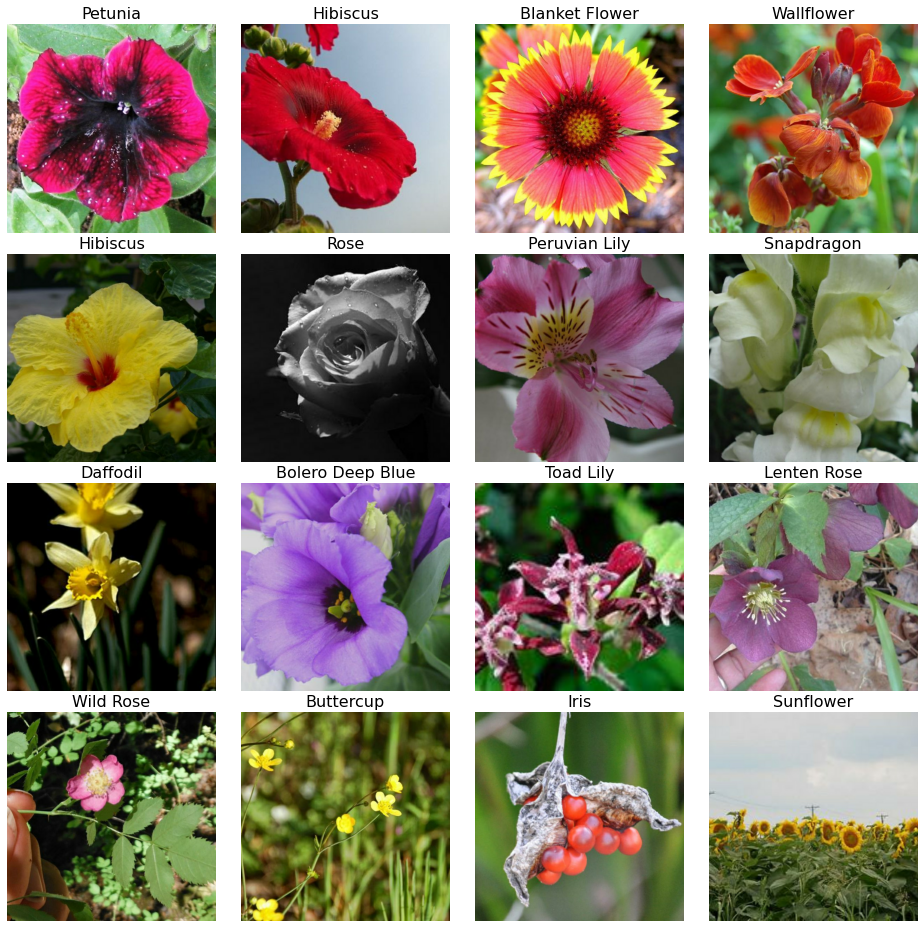

In [8]:
display_16_flowers_from_dataset(load_dataset(VALIDATION_FILENAMES,labeled=True),test=False)

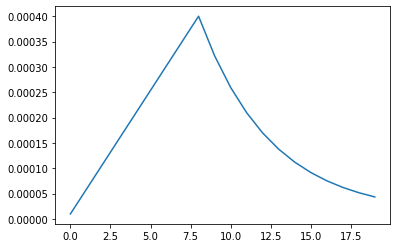

In [9]:
lr_callback = learning_rate_callback()

In [10]:
#Creating the model
with strategy.scope():
    enet = efn.EfficientNetB0(
    input_shape = (512,512,3),
    weights = 'imagenet',
    include_top = False)
    enet.trainable = True
    
    model = tf.keras.Sequential([
        enet,
        #pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES),activation = 'softmax',dtype=tf.float32)
    ])

    model.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )

model.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 16, 16, 1280)      4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               133224    
Total params: 4,182,788
Trainable params: 4,140,772
Non-trainable params: 42,016
_________________________________________________________________


In [11]:
#Fine tuning the model by training
filepath = "model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint, lr_callback]

start_time = time.time()
hist = model.fit(training_dataset, validation_data = validation_dataset,steps_per_epoch = TRAIN_STEPS, epochs = EPOCHS, callbacks = callbacks )
final_accuracy = hist.history["val_accuracy"][-5:]

print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
99/99 [==============================] - 92s 406ms/step - loss: 4.6477 - accuracy: 0.0199 - val_loss: 4.6256 - val_accuracy: 0.0175

Epoch 00001: val_accuracy improved from -inf to 0.01751, saving model to model.hdf5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 5.875e-05.
99/99 [==============================] - 31s 312ms/step - loss: 4.0727 - accuracy: 0.1794 - val_loss: 3.0349 - val_accuracy: 0.3847

Epoch 00002: val_accuracy improved from 0.01751 to 0.38470, saving model to model.hdf5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001075.
99/99 [==============================] - 31s 313ms/step - loss: 2.5071 - accuracy: 0.4562 - val_loss: 1.5276 - val_accuracy: 0.6598

Epoch 00003: val_accuracy improved from 0.38470 to 0.65975, saving model to model.hdf5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00015625.
99/99 [===

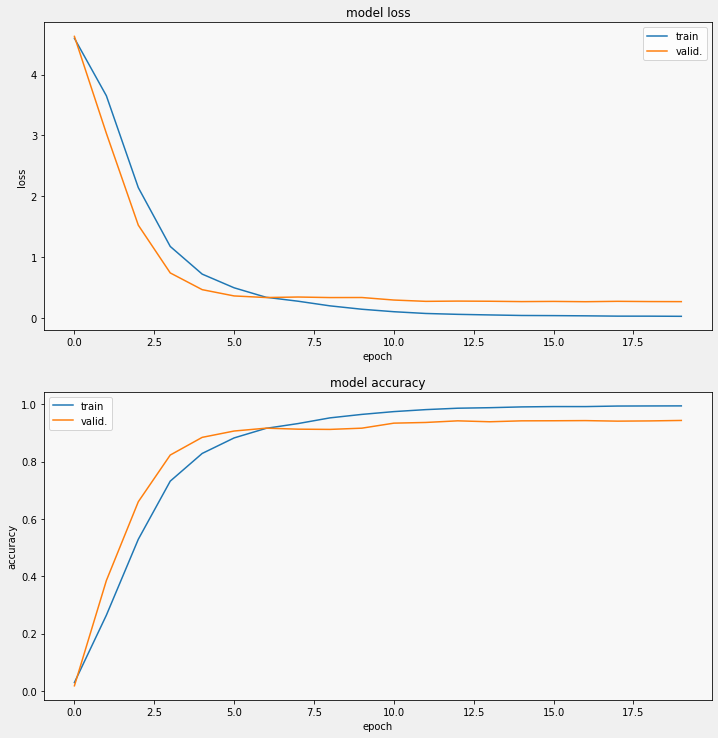

In [12]:
#Visualizing training curves
display_training_curves(hist.history['loss'], hist.history['val_loss'], 'loss', 211)
display_training_curves(hist.history['accuracy'], hist.history['val_accuracy'], 'accuracy', 212)

In [13]:
model.save('plant_model.hdf5')